## <u>*Classsification Modelling for Area as a Target Feature*</u>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
import os

In [2]:
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBRFClassifier
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
import warnings                                  
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK,Trials

---

In [3]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/data_car.csv")
df=df.drop(["X_OBSTAT_","clm","numclaims"],axis=1)
df["agecat"]=df["agecat"].astype("object")
df["veh_age"]=df["veh_age"].astype("object")
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.06,0.303901,0.0,HBACK,3,F,C,2
1,1.03,0.648871,0.0,HBACK,2,F,A,4
2,3.26,0.569473,0.0,UTE,2,F,E,2
3,4.14,0.317591,0.0,STNWG,2,F,D,2
4,0.72,0.648871,0.0,HBACK,4,F,C,2


In [4]:
df=df.sort_values(by=['veh_age', 'agecat','area','gender']).reset_index().drop("index",axis=1)
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.59,0.229979,0.0,SEDAN,1,F,A,1
1,1.46,0.221766,0.0,HBACK,1,F,A,1
2,1.54,0.238193,0.0,SEDAN,1,F,A,1
3,1.57,0.522930,0.0,SEDAN,1,F,A,1
4,1.41,0.219028,0.0,HBACK,1,F,A,1


*Date preprocessing*

In [5]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

In [6]:
df=df[df["claimcst0"]>0]
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
21,2.560,0.810404,11653.230000,4,0,0,0,0
40,1.399,0.862423,1259.189999,3,0,0,0,0
50,3.130,0.407940,850.830000,10,0,0,0,0
63,1.399,0.358658,367.730000,3,0,0,0,0
65,1.470,0.353183,200.000000,3,0,0,0,0


*Define x and y*

In [7]:
x=df.drop("area",axis=1)
y=df["area"]

In [8]:
sc=StandardScaler()
for col in x:
        x[[col]]=StandardScaler().fit_transform(x[[col]])

In [9]:
df["area"].value_counts()

area
2    1412
0    1085
1     965
3     496
4     386
5     280
Name: count, dtype: int64

*apply data balance method*

In [10]:
from imblearn.over_sampling import SMOTE
smk=SMOTE(random_state=41)
x,y=smk.fit_resample(x,y)

*Splitting data into training and testing subsets*

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.25)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (6354, 7) and Y = (6354,) : 
Test data shape of X = (2118, 7) and Y = (2118,) : 


In [23]:
def evaluation_preds(y_true,predicted):
    accuracy=accuracy_score(y_true,predicted)
    metrics_dict={
       "accuracy": round(accuracy,3),
    
    }
   
    return metrics_dict

---

## *Hyperparamers tunning*

* *Defining models and its parameters*

In [37]:
models = {
        
        "XGBRFClassifier": XGBRFClassifier(),
        "GradientBoostingClassifier":GradientBoostingClassifier(),
        "RandomForestClassifier": RandomForestClassifier(),
        "AdaBoostClassifier":AdaBoostClassifier(),
        "DecisionTreeClassifier": DecisionTreeClassifier(),
        
}

search_spaces ={        
        "XGBRFClassifier":{
            "learning_rate": hp.uniform("learning_rate",0.01,1.0),    # 0.3 is the default
            "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
            "subsample": hp.uniform("subsample",0.5,1.0),
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            'colsample_bytree': hp.uniform("colsample_bytree",0.5,1.0), 
            'colsample_bynode': hp.uniform("colsample_bynode",0.5,1.0),
            "reg_lambda": hp.quniform("reg_lambda",0,2,1),           #L2 regularization term on weights. Increasing this value will make model more conservative
            "reg_alpha": hp.quniform("reg_alpha",0,2,1),
            "num_parallel_tree": hp.choice("num_parallel_tree", [100,110])
            },
        "GradientBoostingClassifier":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            "max_depth": hp.choice("max_depth", [None,2, 4, 5, 6,7,8]),
            "max_features": hp.choice("max_features",["sqrt", "log2"]),
            "learning_rate": hp.uniform("learning_rate",0.01,1.0),
            "subsample": hp.uniform("subsample",0.8,1.0),
            "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
            "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0)
            },
        "RandomForestClassifier":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]), 
            "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
            "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0),
            #"max_features": hp.choice("max_features",["sqrt", "log2"]),                                    
            "max_depth": hp.choice("max_depth", [None,2, 4, 5, 6,7,8])
            #"bootstrap": hp.choice("bootstrap",[True, False]),                                                                                                    
            #"criterion": hp.choice("criterion",["gini", "entropy", "log_loss"])                    
        },
        "AdaBoostClassifier":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            "learning_rate": hp.uniform("learning_rate",0.01,1.0)
        },
        "DecisionTreeClassifier": {
                    "criterion": hp.choice("criterion",["gini", "entropy", "log_loss"]),
                    'splitter': hp.choice("splitter",["best", "random"]),
                    "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
                    "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
                    "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0),
                    "max_features": hp.choice("max_features",["sqrt", "log2"])
        }                    
}

In [14]:
np.random.seed(42)
clf=RandomForestClassifier()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)

In [15]:
accuracy_score(y_test,predicted)

0.5420207743153919

In [19]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.43      0.39      0.41       369
           1       0.40      0.36      0.38       358
           2       0.34      0.34      0.34       341
           3       0.63      0.64      0.63       373
           4       0.69      0.71      0.70       331
           5       0.73      0.82      0.77       346

    accuracy                           0.54      2118
   macro avg       0.53      0.54      0.54      2118
weighted avg       0.53      0.54      0.54      2118



<Axes: >

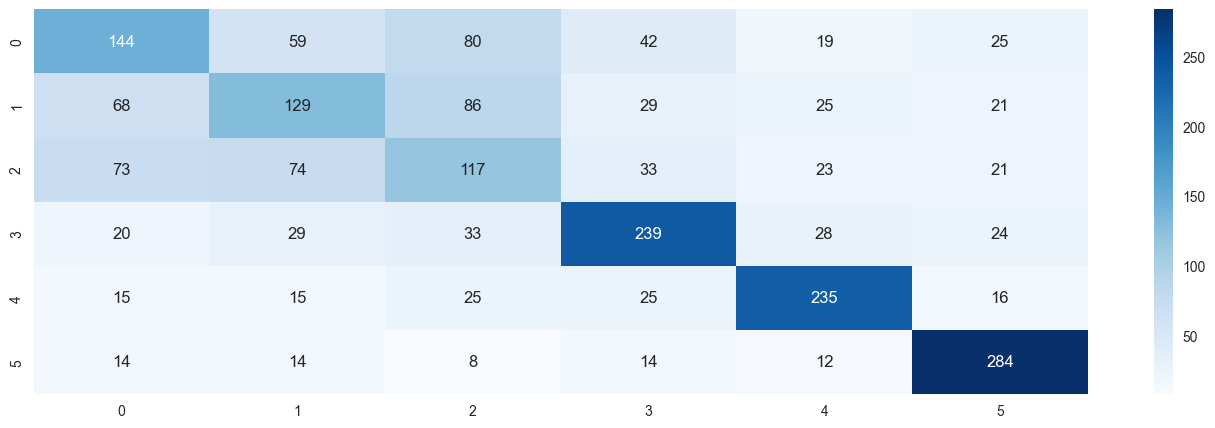

In [20]:
fig=plt.figure(figsize=(17,5))
sns.heatmap(confusion_matrix(y_test,predicted),annot = True, fmt = ".0f",cmap="Blues")

In [24]:

print("===========================================rf_base_evaluation===========================================")
np.random.seed(42)
clf=RandomForestClassifier()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
rf_base_evaluation=evaluation_preds(y_test,predicted)
print("RF_cross_val_evaluation_preds :\n" , rf_base_evaluation)
print("===========")

print("===========================================XGBRF_base_evaluation===========================================")
np.random.seed(42)
clf=XGBRFClassifier()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
XGBRF_base_evaluation=evaluation_preds(y_test,predicted)
print("RF_cross_val_evaluation_preds :\n" , XGBRF_base_evaluation)
print("===========")

print("===========================================ADAboost_base_evaluation===========================================")
np.random.seed(42)
clf=AdaBoostClassifier()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
ADAboost_base_evaluation=evaluation_preds(y_test,predicted)
print("RF_cross_val_evaluation_preds :\n" , ADAboost_base_evaluation)
print("===========")

print("===========================================GradientBoostingClassifier===========================================")
np.random.seed(42)
clf=GradientBoostingClassifier()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
GBOOST_base_evaluation=evaluation_preds(y_test,predicted)
print("RF_cross_val_evaluation_preds :\n" , GBOOST_base_evaluation)
print("==================================================================")  

===========================================rf_base_evaluation===========================================
RF_cross_val_evaluation_preds :
 {'accuracy': 0.542}
===========================================XGBRF_base_evaluation===========================================
RF_cross_val_evaluation_preds :
 {'accuracy': 0.341}
===========================================ADAboost_base_evaluation===========================================
RF_cross_val_evaluation_preds :
 {'accuracy': 0.293}
===========================================GradientBoostingClassifier===========================================
RF_cross_val_evaluation_preds :
 {'accuracy': 0.363}


In [25]:
np.random.seed(42)
basemodels=pd.DataFrame({
    "rf_base_evaluation":rf_base_evaluation,
    "ADAboost_base_evaluation":ADAboost_base_evaluation,
    "XGBRF_base_evaluation":XGBRF_base_evaluation,
    "GBOOST_base_evaluation":GBOOST_base_evaluation
})
basemodels

,rf_base_evaluation,ADAboost_base_evaluation,XGBRF_base_evaluation,GBOOST_base_evaluation
accuracy,0.542,0.293,0.341,0.363


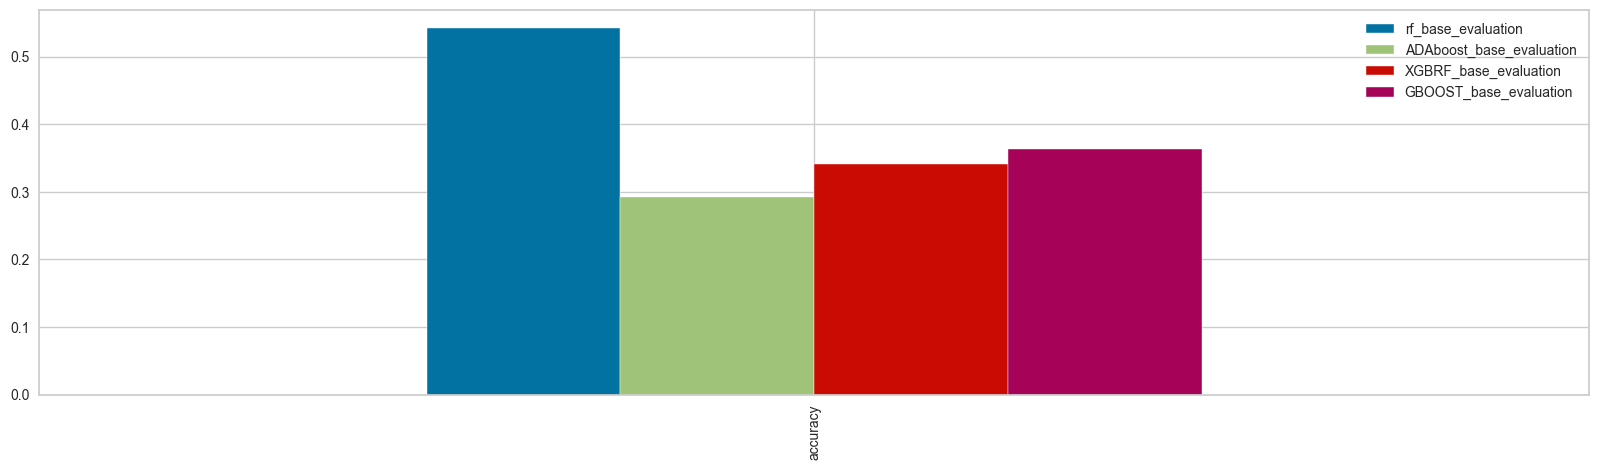

In [27]:
basemodels.plot(kind="bar",figsize=(20,5));

* *AdaBoostClassifier hyperparameter*

In [38]:
space=search_spaces["AdaBoostClassifier"]
def hyperparameter_tuning(space):
    clf = AdaBoostClassifier(**space)
    clf.fit(x_train,y_train)
    acc = accuracy_score(y_test,clf.predict(x_test))
    return {"loss": acc, "status": STATUS_OK}

trials = Trials()
best_AdaBoostClassifier = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)   

100%|██████████| 10/10 [00:37<00:00,  3.77s/trial, best loss: 0.27148253068932954]


* *GradientBoostingClassifier hyperparameter*

In [42]:
space=search_spaces["GradientBoostingClassifier"]
def hyperparameter_tuning(space):
    clf = GradientBoostingClassifier(**space)
    clf.fit(x_train,y_train)
    acc = accuracy_score(y_test,clf.predict(x_test))
    return {"loss": acc, "status": STATUS_OK}

trials = Trials()
best_GradientBoostingClassifier = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)

100%|██████████| 10/10 [00:35<00:00,  3.51s/trial, best loss: 0.1562795089707271]


* *RandomForestClassifier hyperparameter*

In [30]:
space=search_spaces["RandomForestClassifier"]
def hyperparameter_tuning(space):
    clf = RandomForestClassifier(**space)
    clf.fit(x_train,y_train)
    acc = accuracy_score(y_test,clf.predict(x_test))
    return {"loss": acc, "status": STATUS_OK}

trials = Trials()
best_RandomForestClassifier = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)         

100%|██████████| 10/10 [00:08<00:00,  1.24trial/s, best loss: 0.1562795089707271]


* *XGBRFClassifier hyperparameter*

In [31]:
space=search_spaces["XGBRFClassifier"]
def hyperparameter_tuning(space):
    clf = XGBRFClassifier(**space)
    clf.fit(x_train,y_train)
    acc = accuracy_score(y_test,clf.predict(x_test))
    return {"loss": acc, "status": STATUS_OK}

trials = Trials()
best_XGBRFClassifier = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)      

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:59<00:00,  5.96s/trial, best loss: 0.2705382436260623]


In [43]:
print("===========================================best_AdaBoostClassifier===========================================")
model = AdaBoostClassifier(**best_AdaBoostClassifier)
model.fit(x_train,y_train)
predicted=model.predict(x_test)
print("evaluation_preds :\n" , evaluation_preds(y_test,predicted))
ADAboost_evaluation_preds=evaluation_preds(y_test,predicted) 
print("===========")

print("===========================================GradientBoostingClassifier===========================================")
model = GradientBoostingClassifier(**best_GradientBoostingClassifier)
model.fit(x_train,y_train)
predicted=model.predict(x_test)
print("evaluation_preds :\n" , evaluation_preds(y_test,predicted))
GBOOST_evaluation_preds=evaluation_preds(y_test,predicted)  
print("===========")

print("===========================================XGBRFClassifier===========================================")
model = XGBRFClassifier(**best_XGBRFClassifier)
model.fit(x_train,y_train)
predicted=model.predict(x_test)
print("evaluation_preds :\n" , evaluation_preds(y_test,predicted))
XGBRF_evaluation_preds=evaluation_preds(y_test,predicted)     
print("===========")

print("===========================================RandomForestClassifier===========================================")
model = RandomForestClassifier(**best_RandomForestClassifier)
model.fit(x_train,y_train)
predicted=model.predict(x_test)
print("evaluation_preds :\n" , evaluation_preds(y_test,predicted))
RF_evaluation_preds=evaluation_preds(y_test,predicted)
print("===========")

===========================================best_AdaBoostClassifier===========================================
evaluation_preds :
 {'accuracy': 0.244}
===========================================GradientBoostingClassifier===========================================
evaluation_preds :
 {'accuracy': 0.156}
===========================================XGBRFClassifier===========================================
evaluation_preds :
 {'accuracy': 0.39}
===========================================RandomForestClassifier===========================================
evaluation_preds :
 {'accuracy': 0.163}


In [44]:
import json
# Serializing json
json_object = json.dumps({
    "best_AdaBoostClassifier" : best_AdaBoostClassifier,
    "best_GradientBoostingClassifier" :best_GradientBoostingClassifier,
    "best_RandomForestClassifier" :best_RandomForestClassifier,
    "best_XGBRFClassifier" :best_XGBRFClassifier}, indent=4,default=str)
 
# Writing to sample.json
with open("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestParams/area_classification_all_best_params.json", "w") as f:
    f.write(json_object)

In [45]:
import json
# Serializing json
json_object = json.dumps({"ADAboost_evaluation_preds" : ADAboost_evaluation_preds,
    "GBOOST_evaluation_preds" :GBOOST_evaluation_preds,
    "XGBRF_evaluation_preds" :XGBRF_evaluation_preds,
    "RF_evaluation_preds" :RF_evaluation_preds,
    "rf_base_evaluation":rf_base_evaluation,
    "ADAboost_base_evaluation":ADAboost_base_evaluation,
    "XGBRF_base_evaluation":XGBRF_base_evaluation,
    "GBOOST_base_evaluation":GBOOST_base_evaluation}, indent=4)
 
# Writing to sample.json
with open("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/modelsEvaluations/area_classification_all_evaluations.json", "w") as f:
    f.write(json_object)

In [47]:
comparison=pd.DataFrame({
    "ADAboost_evaluation_preds" : ADAboost_evaluation_preds,
    "GBOOST_evaluation_preds" :GBOOST_evaluation_preds,
    "XGBRF_evaluation_preds" :XGBRF_evaluation_preds,
    "RF_evaluation_preds" :RF_evaluation_preds,
    "rf_base_evaluation":rf_base_evaluation,
    "ADAboost_base_evaluation":ADAboost_base_evaluation,
    "XGBRF_base_evaluation":XGBRF_base_evaluation,
    "GBOOST_base_evaluation":GBOOST_base_evaluation
})
comparison


,ADAboost_evaluation_preds,GBOOST_evaluation_preds,XGBRF_evaluation_preds,RF_evaluation_preds,rf_base_evaluation,ADAboost_base_evaluation,XGBRF_base_evaluation,GBOOST_base_evaluation
accuracy,0.244,0.156,0.39,0.163,0.542,0.293,0.341,0.363


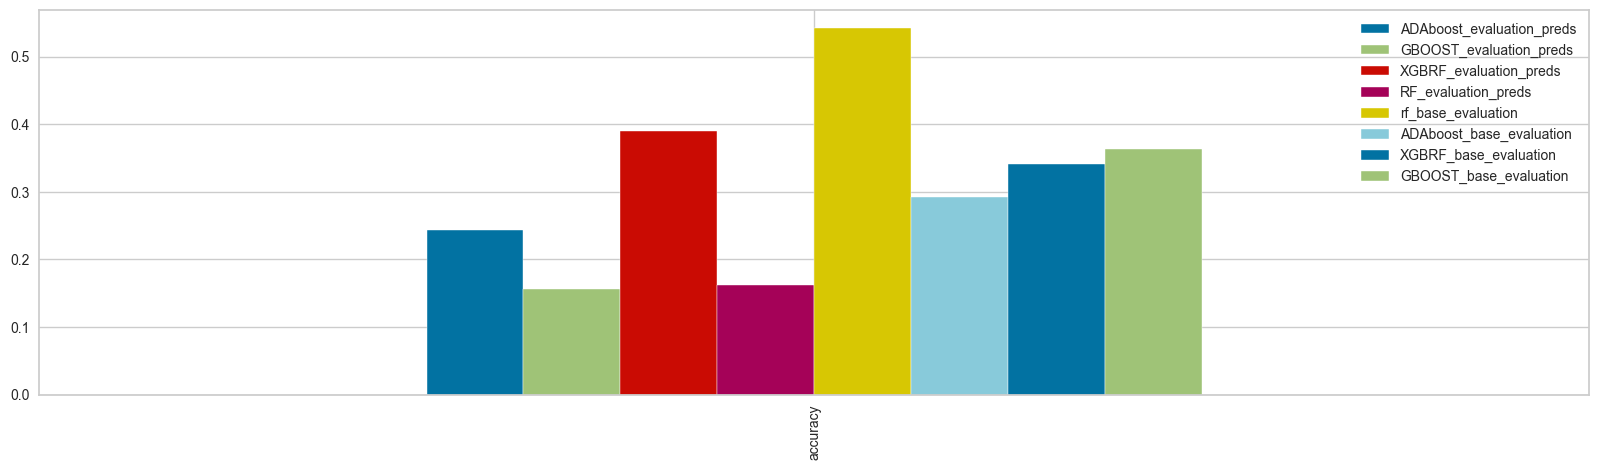

In [49]:
comparison.plot(kind="bar",figsize=(20,5))
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/modelsEvaluationsGraphs/area_EvaluationsGraph.png',dpi=500); 


### *Final Result*

In [51]:
np.random.seed(42)
clf=RandomForestClassifier()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
print(classification_report(y_test,predicted))


              precision    recall  f1-score   support

           0       0.43      0.39      0.41       369
           1       0.40      0.36      0.38       358
           2       0.34      0.34      0.34       341
           3       0.63      0.64      0.63       373
           4       0.69      0.71      0.70       331
           5       0.73      0.82      0.77       346

    accuracy                           0.54      2118
   macro avg       0.53      0.54      0.54      2118
weighted avg       0.53      0.54      0.54      2118



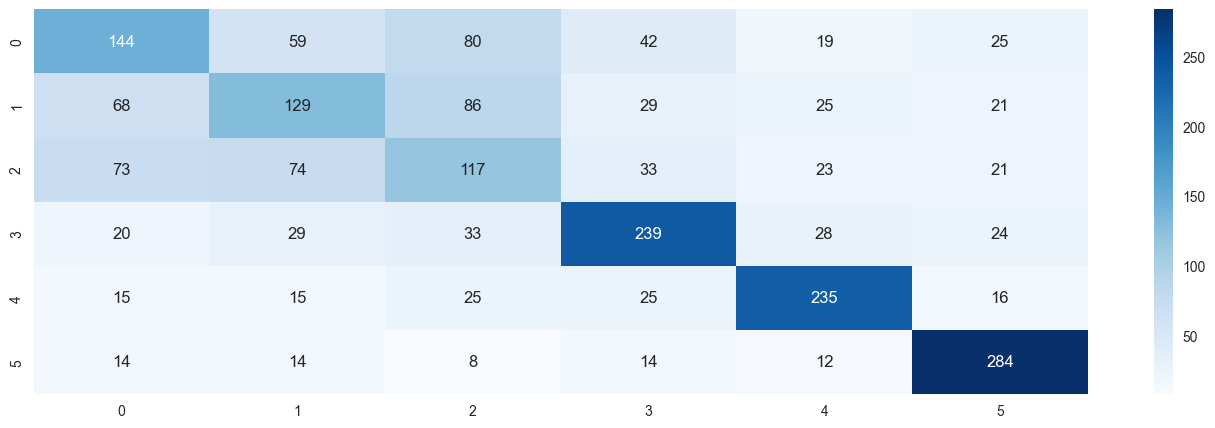

In [56]:
fig=plt.figure(figsize=(17,5))
sns.heatmap(confusion_matrix(y_test,predicted),annot = True, fmt = ".0f",cmap="Blues")
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/confusionMatrixGraphs/area_confusion_matrixPlot.png',dpi=500); 

In [55]:
pd.crosstab(y_test,predicted,rownames=["Actual"],colnames=["predicted"])

predicted,0,1,2,3,4,5
Actual,,,,,,
0,144,59,80,42,19,25
1,68,129,86,29,25,21
2,73,74,117,33,23,21
3,20,29,33,239,28,24
4,15,15,25,25,235,16
5,14,14,8,14,12,284


In [57]:
clf.feature_names_in=x.columns
importance=pd.concat([pd.DataFrame(clf.feature_names_in,columns=["feature_names"]),
           pd.DataFrame(clf.feature_importances_,columns=["feature_importances"])],axis=1)
importance

,feature_names,feature_importances
0,veh_value,0.227903
1,exposure,0.222400
2,claimcst0,0.207793
3,veh_body,0.102199
4,veh_age,0.080084
5,gender,0.035512
6,agecat,0.124109


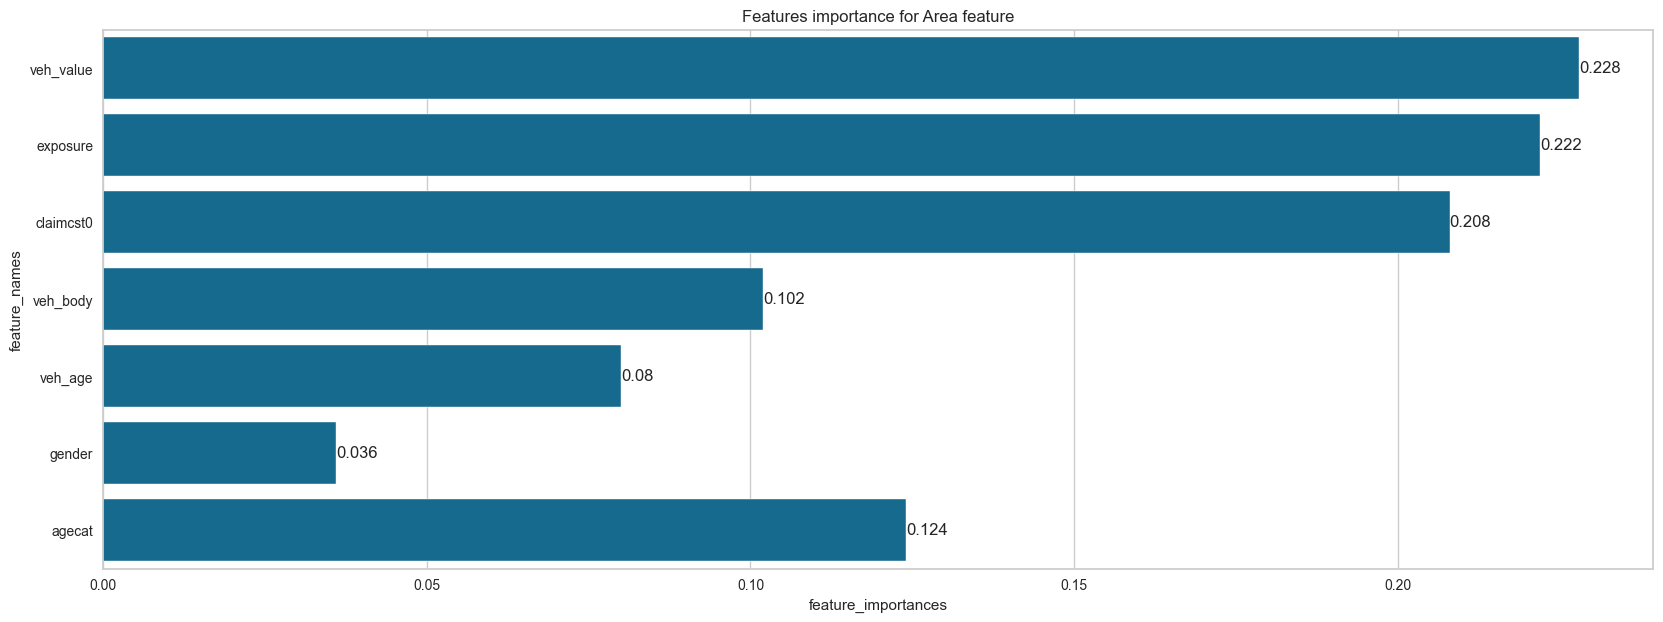

In [58]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for Area feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresImportanceGraphs/area_featureImportanc.png',dpi=500);

In [59]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestModels/area_prediction_model.pkl","wb") as f:
    pickle.dump(clf,f)